In [295]:
import pandas as pd
features = pd.read_csv('data-processed\\dengue_features_train.csv')
labels = pd.read_csv('data-processed\\dengue_labels_train.csv')
test = pd.read_csv('data-processed\\dengue_features_test.csv')
features = features.merge(labels,how='inner')

In [296]:
iq_train,sj_train = features[features.city == 'iq'],features[features.city == 'sj']
iq_test,sj_test = test[test.city == 'iq'],test[test.city == 'sj']
iq_label,sj_label = labels[labels.city == 'iq'],labels[labels.city == 'sj']
# iq_train.head()

In [297]:
# iq_train.describe()

In [298]:
# 统计各列的缺失值数量
# print(len(iq_train['city']))
# iq_train.isna().sum()
# print(len(sj_train['city']))
# sj_train.isna().sum()

In [299]:
import warnings
warnings.filterwarnings("ignore")
# 方法一：填补训练集缺失值
# iq_train.fillna(method='ffill',inplace=True)
# sj_train.fillna(method='ffill',inplace=True)

# 方法二：填补训练集缺失值
import warnings
warnings.filterwarnings("ignore")
import numpy as np
iq_train = iq_train.replace(to_replace=np.nan,value=0)
sj_train = sj_train.replace(to_replace=np.nan,value=0)


for column in iq_test.columns:
    for i in list(iq_test.index):
        if iq_test[column][i] == 0:
            temp_list = list()
            for m in list(iq_test.index):
                if iq_test[column][m]>0:
                    temp_list.append(iq_test[column][m])
            iq_test[column][i] = np.mean(temp_list) + np.random.choice(np.arange(-np.std(temp_list,ddof=1), np.std(temp_list,ddof=1), 0.01))
                
for column in sj_test.columns:
        for i in list(sj_test.index):
            if sj_test[column][i] == 0:
                temp_list = list()
                for m in list(sj_test.index):
                    if sj_test[column][m]>0:
                        temp_list.append(sj_test[column][m])
                sj_test[column][i] = np.mean(temp_list) + np.random.choice(np.arange(-np.std(temp_list,ddof=1), np.std(temp_list,ddof=1), 0.01))

# 方法三：均值插值法
# for f in iq_train.columns:
#     iq_train[f] = iq_train[f].interpolate(method='slinear')
# for f in sj_train.columns:
#     sj_train[f] = sj_train[f].interpolate(method='slinear')
    
# 方法四：KNN插值法（模块安装失败）
# from fancyimpute import KNN
# fill_knn = KNN(k=3).fit_transform(iq_train)
# iq_train = pd.DataFrame(fill_knn)

# fill_knn = KNN(k=3).fit_transform(sj_train)
# sj_train = pd.DataFrame(fill_knn)

In [300]:
# 方法一：填补测试集缺失值
# iq_test.fillna(method='ffill',inplace=True)
# sj_test.fillna(method='ffill',inplace=True)

# 方法二：填补测试集缺失值
import warnings
warnings.filterwarnings("ignore")
import numpy as np
iq_test = iq_test.replace(to_replace=np.nan,value=0)
sj_test = sj_test.replace(to_replace=np.nan,value=0)

for column in iq_test.columns:
    for i in list(iq_test.index):
        if iq_test[column][i] == 0:
            temp_list = list()
            for m in list(iq_test.index):
                if iq_test[column][m]>0:
                    temp_list.append(iq_test[column][m])
            iq_test[column][i] = np.mean(temp_list) + np.random.choice(np.arange(-np.std(temp_list,ddof=1), np.std(temp_list,ddof=1), 0.01))

for column in sj_test.columns:
        for i in list(sj_test.index):
            if sj_test[column][i] == 0:
                temp_list = list()
                for m in list(sj_test.index):
                    if sj_test[column][m]>0:
                        temp_list.append(sj_test[column][m])
                sj_test[column][i] = np.mean(temp_list) + np.random.choice(np.arange(-np.std(temp_list,ddof=1), np.std(temp_list,ddof=1), 0.01))

# 方法三：标准插值法
for f in iq_test.columns:
    iq_test[f] = iq_test[f].interpolate(method='slinear')
for f in sj_test.columns:
    sj_test[f] = sj_test[f].interpolate(method='slinear')
    
# # 方法四：KNN插值法（模块安装失败）
# from fancyimpute import KNN
# fill_knn = KNN(k=3).fit_transform(iq_test)
# iq_test = pd.DataFrame(fill_knn)

# fill_knn = KNN(k=3).fit_transform(sj_test)
# sj_test = pd.DataFrame(fill_knn)

In [301]:
# print(sum(iq_train.isna().sum()))
# print(sum(sj_train.isna().sum()))

In [302]:
# 特征添加
def add_features(data,week):
    features = list(data.columns)
    remove_list = list()
    for i in ['city','year','weekofyear','week_start_date','total_cases']:
        if i in features:
            remove_list.append(i)
    for j in remove_list:
        features.remove(j)
    # 前week周的数据特征
    for w in range(week):
        for f in features:
            data[str(w+1)+'-'+f] = data.groupby('city')[f].shift(w+1)
    # 填补前week空白数据特征
    for i in range(data.index[0],data.index[0]+week):
        for f in data.columns:
            if pd.isnull(data[f][i]):
                if not pd.isnull(data['1'+f[1:]][i]):
                    data[f][i] = data['1'+f[1:]][i]
                else:
                    data[f][i] = data[f[2:]][i]
    # 其他新特征
    air_temp_diff1 = list()
    air_temp_diff2 = list()
    total_ndvi = list()
    air_temp_avg1 = list()
    air_temp_avg2 = list()
    air_temp_avg3 = list()
    precip_avg1 = list()
    precip_avg2 = list()
    precip_avg3 = list()
    humidity_avg1 = list()
    humidity_avg2 = list()
    point_avg = list()
    tdtr_avg = list()
    diur_avg = list()
    ndvi_se_avg = list()
    ndvi_sw_avg = list()
    ndvi_ne_avg = list()
    ndvi_nw_avg = list()

    air_temp_avg_value1 = np.mean(data['reanalysis_avg_temp_k'])
    air_temp_avg_value2 = np.mean(data['station_avg_temp_c'])
    air_temp_avg_value3 = np.mean(data['reanalysis_air_temp_k'])

    precip_avg_value1 = np.mean(data['reanalysis_sat_precip_amt_mm'])
    precip_avg_value2 = np.mean(data['reanalysis_precip_amt_kg_per_m2'])
    precip_avg_value3 = np.mean(data['station_precip_mm'])

    humidity_avg_value1 = np.mean(data['reanalysis_relative_humidity_percent'])
    humidity_avg_value2 = np.mean(data['reanalysis_specific_humidity_g_per_kg'])

    point_avg_value = np.mean(data['reanalysis_dew_point_temp_k'])

    tdtr_avg_value = np.mean(data['reanalysis_tdtr_k'])
    diur_avg_value = np.mean(data['station_diur_temp_rng_c'])
    
    ndvi_se_avg_value = np.mean(data['ndvi_se'])
    ndvi_sw_avg_value = np.mean(data['ndvi_sw'])
    ndvi_ne_avg_value = np.mean(data['ndvi_ne'])
    ndvi_nw_avg_value = np.mean(data['ndvi_nw'])

    for i in list(data.index):
        # (温差1)
        air_temp_diff1.append(data['reanalysis_max_air_temp_k'][i]-data['reanalysis_min_air_temp_k'][i])
        # (温差2)
        air_temp_diff2.append(data['station_max_temp_c'][i]-data['station_min_temp_c'][i])
        # (植被总和)
        temp_sum = data['ndvi_se'][i]+data['ndvi_sw'][i]+data['ndvi_ne'][i]+data['ndvi_nw'][i]
        total_ndvi.append(temp_sum)
        # (与均温差)
        air_temp_avg1.append(data['reanalysis_avg_temp_k'][i]-air_temp_avg_value1)
        air_temp_avg2.append(data['station_avg_temp_c'][i]-air_temp_avg_value2)
        air_temp_avg3.append(data['reanalysis_air_temp_k'][i]-air_temp_avg_value3)
        # (与均降水差)
        precip_avg1.append(data['reanalysis_sat_precip_amt_mm'][i]-precip_avg_value1)
        precip_avg2.append(data['reanalysis_precip_amt_kg_per_m2'][i]-precip_avg_value2)
        precip_avg3.append(data['station_precip_mm'][i]-precip_avg_value3)
        # (与均湿度差)
        humidity_avg1.append(data['reanalysis_relative_humidity_percent'][i]-humidity_avg_value1)
        humidity_avg2.append(data['reanalysis_specific_humidity_g_per_kg'][i]-humidity_avg_value2)
        # (与均露点差)
        point_avg.append(data['reanalysis_dew_point_temp_k'][i]-point_avg_value)
        # (与均温差日较差)tdtr
        tdtr_avg.append(data['reanalysis_tdtr_k'][i]-tdtr_avg_value)
        # (与均温差日较差)diur
        diur_avg.append(data['station_diur_temp_rng_c'][i]-diur_avg_value)
        # 植被均差
        ndvi_se_avg.append(data['ndvi_se'][i]-ndvi_se_avg_value)
        ndvi_sw_avg.append(data['ndvi_sw'][i]-ndvi_sw_avg_value)
        ndvi_ne_avg.append(data['ndvi_ne'][i]-ndvi_ne_avg_value)
        ndvi_nw_avg.append(data['ndvi_nw'][i]-ndvi_nw_avg_value)

    data['air_temp_diff1'] = air_temp_diff1
    data['air_temp_diff2'] = air_temp_diff2
    data['total_ndvi'] = total_ndvi
    data['air_temp_avg1'] = air_temp_avg1 
    data['air_temp_avg2'] = air_temp_avg2
    data['air_temp_avg3'] = air_temp_avg3 
    data['precip_avg1'] = precip_avg1 
    data['precip_avg2'] = precip_avg2
    data['precip_avg3'] = precip_avg3
    data['humidity_avg1'] = humidity_avg1 
    data['humidity_avg2'] = humidity_avg2 
    data['point_avg'] = point_avg 
    data['tdtr_avg'] = tdtr_avg 
    data['diur_avg'] = diur_avg
    data['ndvi_se_avg'] = ndvi_se_avg
    data['ndvi_sw_avg'] = ndvi_sw_avg
    data['ndvi_ne_avg'] = ndvi_ne_avg
    data['ndvi_nw_avg'] = ndvi_nw_avg
    return data

In [303]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
week = 3
iq_train = add_features(iq_train,week)
sj_train = add_features(sj_train,week)
iq_test = add_features(iq_test,week)
sj_test = add_features(sj_test,week)

In [304]:
# print(sum(iq_train.isna().sum()))
# print(sum(sj_train.isna().sum()))

In [305]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
# use random forest for feature selection
rfc = RandomForestRegressor()

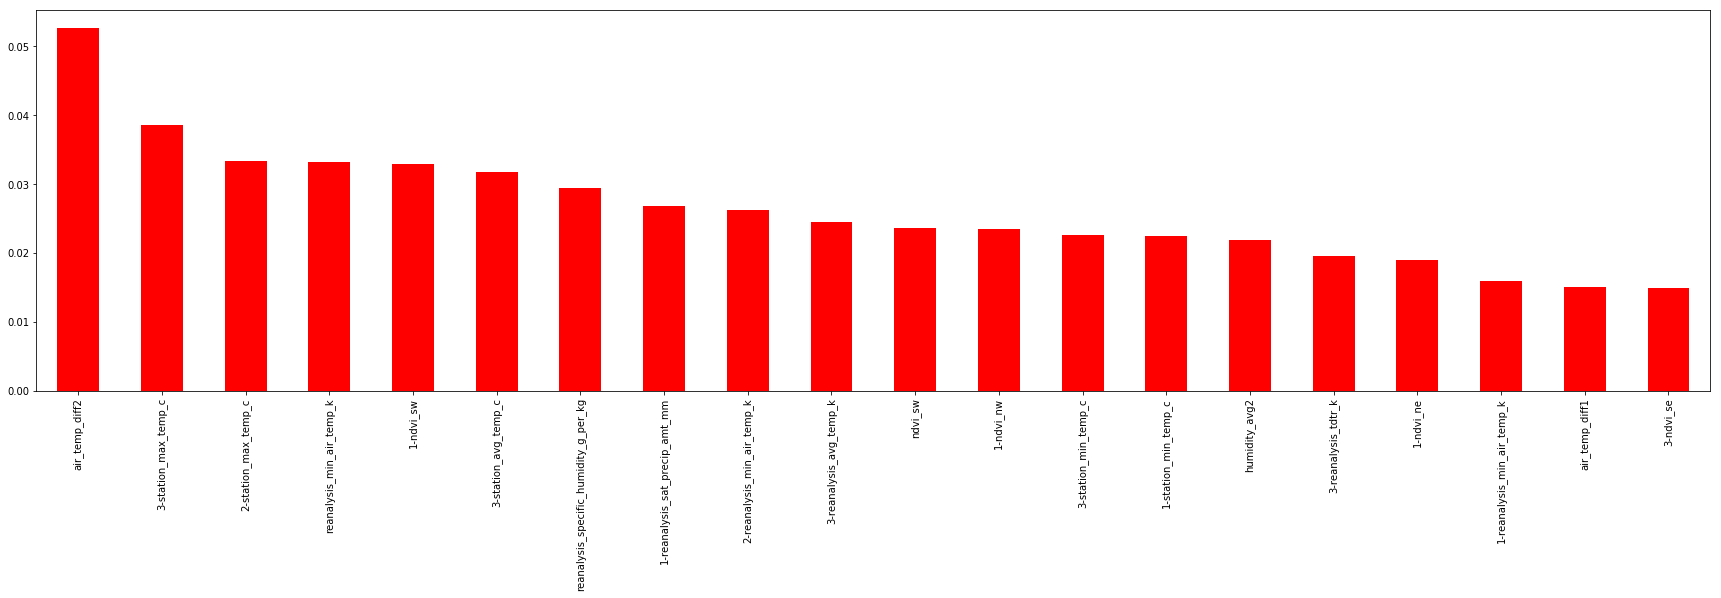

In [306]:
iq_df = iq_train.drop(['city', 'year', 'weekofyear', 'week_start_date','total_cases'], axis = 1)
sj_df = sj_train.drop(['city', 'year', 'weekofyear', 'week_start_date','total_cases'], axis = 1)

iq_test_df = iq_test.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis = 1)
sj_test_df = sj_test.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis = 1)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 特征归一化
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

iq_temp_train_values = scaler.fit_transform(iq_df)
iq_df = pd.DataFrame(iq_temp_train_values, columns = iq_df.columns)

sj_temp_train_values = scaler.fit_transform(sj_df)
sj_df = pd.DataFrame(sj_temp_train_values, columns = sj_df.columns)

iq_temp_test_values = scaler.fit_transform(iq_test_df)
iq_test_df = pd.DataFrame(iq_temp_test_values, columns = iq_test_df.columns)

sj_temp_test_values = scaler.fit_transform(sj_test_df)
sj_test_df = pd.DataFrame(sj_temp_test_values, columns = sj_test_df.columns)

iq_df = pd.DataFrame(iq_df, columns = iq_df.columns)
sj_df = pd.DataFrame(sj_df, columns = sj_df.columns)
iq_test_df = pd.DataFrame(iq_test_df, columns = iq_test_df.columns)
sj_test_df = pd.DataFrame(sj_test_df, columns = sj_test_df.columns)

rfc.fit(iq_df, iq_label['total_cases'])
# print(rfc.feature_importances_)
plt.figure(figsize=(30, 7))
features = pd.Series(rfc.feature_importances_, index= iq_df.columns)
features.nlargest(20).plot(kind = 'bar', color = 'r')
# plt.show()

In [307]:
print(len(list(iq_df.columns)))
print(features.nlargest(80))
features.nlargest(80).index

98
air_temp_diff2                             0.052606
3-station_max_temp_c                       0.038507
2-station_max_temp_c                       0.033259
reanalysis_min_air_temp_k                  0.033239
1-ndvi_sw                                  0.032891
3-station_avg_temp_c                       0.031756
reanalysis_specific_humidity_g_per_kg      0.029351
1-reanalysis_sat_precip_amt_mm             0.026718
2-reanalysis_min_air_temp_k                0.026172
3-reanalysis_avg_temp_k                    0.024410
ndvi_sw                                    0.023650
1-ndvi_nw                                  0.023447
3-station_min_temp_c                       0.022596
1-station_min_temp_c                       0.022484
humidity_avg2                              0.021876
3-reanalysis_tdtr_k                        0.019482
1-ndvi_ne                                  0.019005
1-reanalysis_min_air_temp_k                0.015867
air_temp_diff1                             0.015073
3-ndvi_se

Index(['air_temp_diff2', '3-station_max_temp_c', '2-station_max_temp_c',
       'reanalysis_min_air_temp_k', '1-ndvi_sw', '3-station_avg_temp_c',
       'reanalysis_specific_humidity_g_per_kg',
       '1-reanalysis_sat_precip_amt_mm', '2-reanalysis_min_air_temp_k',
       '3-reanalysis_avg_temp_k', 'ndvi_sw', '1-ndvi_nw',
       '3-station_min_temp_c', '1-station_min_temp_c', 'humidity_avg2',
       '3-reanalysis_tdtr_k', '1-ndvi_ne', '1-reanalysis_min_air_temp_k',
       'air_temp_diff1', '3-ndvi_se', '1-station_avg_temp_c',
       '1-station_max_temp_c', '2-station_avg_temp_c', '1-ndvi_se',
       'air_temp_avg3', '1-station_diur_temp_rng_c', '2-precipitation_amt_mm',
       '2-reanalysis_tdtr_k', '3-station_diur_temp_rng_c',
       'station_avg_temp_c', 'reanalysis_max_air_temp_k', 'ndvi_se_avg',
       '2-reanalysis_avg_temp_k', '3-reanalysis_min_air_temp_k',
       'precipitation_amt_mm', '1-reanalysis_max_air_temp_k',
       '2-reanalysis_dew_point_temp_k', '2-station_min_temp_c'

In [308]:
iq_features = ['air_temp_diff2', '3-reanalysis_tdtr_k', '1-station_avg_temp_c',
       '1-station_max_temp_c', '3-station_diur_temp_rng_c',
       '3-station_max_temp_c', '1-reanalysis_specific_humidity_g_per_kg',
       '3-station_precip_mm', 'reanalysis_specific_humidity_g_per_kg',
       '1-reanalysis_min_air_temp_k', 'reanalysis_min_air_temp_k']

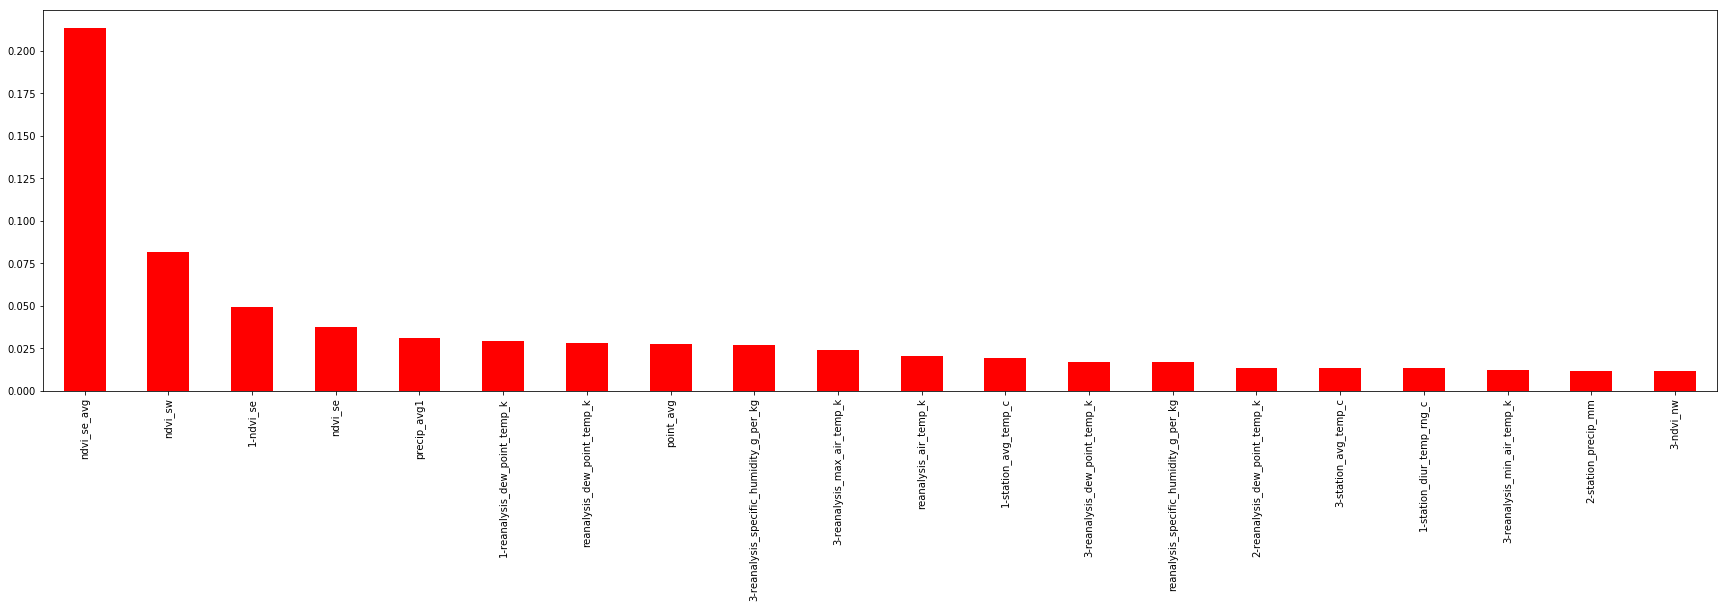

In [309]:
rfc.fit(sj_df, sj_label['total_cases'])
plt.figure(figsize=(30, 7))
features = pd.Series(rfc.feature_importances_, index= sj_df.columns)
features.nlargest(20).plot(kind = 'bar', color = 'r')
# plt.show()

In [310]:
print(len(list(sj_df.columns)))
print(features.nlargest(20))
features.nlargest(20).index

98
ndvi_se_avg                                0.213273
ndvi_sw                                    0.081863
1-ndvi_se                                  0.048985
ndvi_se                                    0.037644
precip_avg1                                0.031044
1-reanalysis_dew_point_temp_k              0.029311
reanalysis_dew_point_temp_k                0.027968
point_avg                                  0.027658
3-reanalysis_specific_humidity_g_per_kg    0.026845
3-reanalysis_max_air_temp_k                0.023691
reanalysis_air_temp_k                      0.020112
1-station_avg_temp_c                       0.019346
3-reanalysis_dew_point_temp_k              0.016900
reanalysis_specific_humidity_g_per_kg      0.016862
2-reanalysis_dew_point_temp_k              0.013523
3-station_avg_temp_c                       0.013257
1-station_diur_temp_rng_c                  0.013096
3-reanalysis_min_air_temp_k                0.012045
2-station_precip_mm                        0.011562
3-ndvi_nw

Index(['ndvi_se_avg', 'ndvi_sw', '1-ndvi_se', 'ndvi_se', 'precip_avg1',
       '1-reanalysis_dew_point_temp_k', 'reanalysis_dew_point_temp_k',
       'point_avg', '3-reanalysis_specific_humidity_g_per_kg',
       '3-reanalysis_max_air_temp_k', 'reanalysis_air_temp_k',
       '1-station_avg_temp_c', '3-reanalysis_dew_point_temp_k',
       'reanalysis_specific_humidity_g_per_kg',
       '2-reanalysis_dew_point_temp_k', '3-station_avg_temp_c',
       '1-station_diur_temp_rng_c', '3-reanalysis_min_air_temp_k',
       '2-station_precip_mm', '3-ndvi_nw'],
      dtype='object')

In [311]:
sj_features = ['ndvi_sw', 'ndvi_se', 'point_avg','3-station_avg_temp_c','station_avg_temp_c', 'station_min_temp_c'
       'reanalysis_specific_humidity_g_per_kg', '1-station_max_temp_c',
       '3-reanalysis_dew_point_temp_k', '2-reanalysis_dew_point_temp_k']

In [312]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb
import catboost as cb

In [313]:
# numr = 0
# maxv = np.mean(iq_train['total_cases'])+5*np.std(iq_train['total_cases'], ddof=1)
# for i in iq_train['total_cases']:
#     if i >=maxv:
#         numr +=1
# print(numr)
# for i in range(numr):
#     iq_train = iq_train.drop(index=[np.argmax(iq_train['total_cases'])])
    
# numr = 0
# maxv = np.mean(sj_train['total_cases'])+5*np.std(sj_train['total_cases'], ddof=1)
# for i in sj_train['total_cases']:
#     if i >=maxv:
#         numr +=1
# print(numr)
# for i in range(numr):
#     sj_train = sj_train.drop(index=[np.argmax(sj_train['total_cases'])])    

In [314]:
# LGBMRegressor                 25.5385
# RandomForestRegressor         25.4856
# SVR                           27.3077
# GradientBoostingRegressor     26.1659
# XGBOOST                       26.1202
# CatBoostRegressor             25.2981

In [315]:
import warnings
warnings.filterwarnings("ignore")
iq_lgbm = LGBMRegressor()
iq_param_grid = {'max_depth': [3, 4, 5, 6,7],'min_samples_leaf': np.arange(2,6,1),'min_samples_split':np.arange(2,6,1)}
iq_gs = GridSearchCV(estimator=iq_lgbm,param_grid=iq_param_grid,cv=3)

# iq_rf = RandomForestRegressor()
# iq_param_grid = {'n_estimators':np.arange(100,400,100),'min_samples_leaf':np.arange(2,6,2),'max_depth':[3,4,5,6]}
# iq_gs = GridSearchCV(estimator=iq_rf,param_grid=iq_param_grid,cv=3)

# iq_svr = SVR()
# iq_param_grid = {'C':[1,10,100,1000],'kernel':['rbf'],'gamma':[0.0001,0.001,0.005,0.01]}
# iq_gs = GridSearchCV(estimator=iq_svr,param_grid=iq_param_grid,cv=3)

# iq_gbr = GradientBoostingRegressor()
# iq_param_grid = {'alpha':[0.7,0.8,0.9],'max_depth':[3,4,5,6],'min_samples_leaf':[1,2,3,4,5],'n_estimators':np.arange(100,500,100)}
# iq_gs = GridSearchCV(estimator=iq_gbr,param_grid=iq_param_grid,cv=3)

# iq_xgb = xgb.XGBRegressor()
# iq_param_grid = {'max_depth':[3,4,5,6,7],'min_child_weight':np.arange(3,10,1),'n_estimators':np.arange(100,300,20)}
# iq_gs = GridSearchCV(estimator=iq_xgb,param_grid=iq_param_grid,cv=3)

# iq_cb = cb.CatBoostRegressor()
# # iq_param_grid = {'learning_rate':[0.01,0.05,0.1,0.15],'l2_leaf_reg':[7,8,9],'iterations':np.arange(300,500,100),'depth':[5,6,7,8,9,10]}
# iq_param_grid = {'learning_rate':[0.01],'l2_leaf_reg':[7],'iterations':[500],'depth':[7]}
# iq_gs = GridSearchCV(estimator=iq_cb,param_grid=iq_param_grid,cv=3)

iq_gs.fit(iq_train[iq_features], iq_train['total_cases'])
print(iq_gs.best_params_)
iq_prediction1 = iq_gs.predict(iq_test[iq_features])

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [316]:
import warnings
warnings.filterwarnings("ignore")
sj_lgbm = LGBMRegressor()
sj_param_grid = {'max_depth': [3, 4, 5, 6, 7],'min_samples_leaf': np.arange(2,6,1),'min_samples_split':np.arange(2,6,1)}
sj_gs = GridSearchCV(estimator=sj_lgbm,param_grid=sj_param_grid,cv=3)

# sj_rf = RandomForestRegressor()
# sj_param_grid = {'n_estimators':np.arange(100,500,100),'min_samples_leaf':np.arange(2,8,2),'max_depth':[2,3,4,5,6]}
# sj_gs = GridSearchCV(estimator=sj_rf,param_grid=sj_param_grid,cv=3)

# sj_svr = SVR()
# sj_param_grid = {'C':[1,10,100,1000],'kernel':['rbf'],'gamma':[0.0001,0.001,0.005,0.01]}
# sj_gs = GridSearchCV(estimator=sj_svr,param_grid=sj_param_grid,cv=3)

# sj_gbr = GradientBoostingRegressor()
# sj_param_grid = {'alpha':[0.7,0.8,0.9],'max_depth':[3,4,5,6,7],'min_samples_leaf':[1,2,3,4,5,6,7],'n_estimators':np.arange(100,300,100)}
# sj_gs = GridSearchCV(estimator=sj_gbr,param_grid=sj_param_grid,cv=3)

# sj_xgb = xgb.XGBRegressor()
# sj_param_grid = {'max_depth':[3,4,5,6],'min_child_weight':np.arange(3,10,1),'n_estimators':np.arange(100,400,10)}
# sj_gs = GridSearchCV(estimator=sj_xgb,param_grid=sj_param_grid,cv=3)

# sj_cb = cb.CatBoostRegressor()
# sj_param_grid = {'learning_rate':[0.01,0.05,0.1,0.15],'l2_leaf_reg':[7,8,9],'iterations':np.arange(300,500,100),'depth':[5,6,7,8,9,10]}
# sj_param_grid = {'learning_rate':[0.01],'l2_leaf_reg':[7],'iterations':[500],'depth':[7]}
# sj_gs = GridSearchCV(estimator=sj_cb,param_grid=sj_param_grid,cv=3)

sj_gs.fit(sj_train[sj_features], sj_train['total_cases'])
print(sj_gs.best_params_)
sj_prediction1= sj_gs.predict(sj_test[sj_features])

KeyError: "['station_min_temp_creanalysis_specific_humidity_g_per_kg'] not in index"

In [ ]:
iq_result = pd.DataFrame()
sj_result = pd.DataFrame()
iq_result[['city', 'year', 'weekofyear']] = iq_test[['city', 'year', 'weekofyear']]
sj_result[['city', 'year', 'weekofyear']] = sj_test[['city', 'year', 'weekofyear']]

In [ ]:
for i in range(len(iq_prediction1)):
    if iq_prediction1[i] < 0:
        iq_prediction1[i] = 0
for i in range(len(sj_prediction1)):
    if sj_prediction1[i] < 0:
        sj_prediction1[i] = 0
iq_result['total_cases'] = iq_prediction1
sj_result['total_cases'] = sj_prediction1

In [ ]:
# iq_result.head()
# sj_result.head()

In [ ]:
frames = [sj_result,iq_result]
result = pd.concat(frames)

In [ ]:
import math
# for i in range(len(result['total_cases'])):
#     result['total_cases'][i] = round(result['total_cases'][i])#四舍五入
#     result['total_cases'][i] = math.floor(result['total_cases'][i])#向下取整
    # math.ceil #向上取整
result['total_cases'] = result['total_cases'].astype(int)
result.to_csv('result.csv',index=None)

In [ ]:
result.head()